# Numerically Controlled Oscillator - Additional Features

In this tutorial we will demonstrate the use of the NCO to carry out some novel experiments. This will be a review of some of the more advanced protocols one can carry out with the Q1 sequencer and the NCO. We will demonstrate the following experiments:

1. Chirping the frequency of a pulse e.g for rapid spectroscopy measurements
2. Phase updates e.g for virtual $Z$ gates

We will show these functionalities using a QRM and directly connecting outputs $\text{O}^{[1-2]}$ to inputs $\text{I}^{[1-2]}$ respectively. We will then use the QRM's sequencers to sequence waveforms on the outputs and simultaneously acquire the resulting waveforms on the inputs.

## Setup

First, we are going to import the required packages and connect to the instrument.

In [1]:

from __future__ import annotations

import json
from typing import TYPE_CHECKING, Callable

import matplotlib.pyplot as plt
import numpy as np
from qcodes.instrument import find_or_create_instrument
from scipy.signal import spectrogram, welch
from scipy.signal.windows import gaussian

from qblox_instruments import Cluster, ClusterType

if TYPE_CHECKING:
    from numpy.typing import NDArray

    from qblox_instruments.qcodes_drivers.module import QcmQrm

### Scan For Clusters

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/api_reference/tools.html#api-pnp) for more info).

In [2]:
!qblox-pnp list

Devices:
 - 10.10.200.13 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.2 with name "QSE_1" and serial number 00015_2321_005
 - 10.10.200.42 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "QAE-I" and serial number 00015_2321_004
 - 10.10.200.43 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.2 with name "QAE-2" and serial number 00015_2206_003
 - 10.10.200.50 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "cluster-mm" and serial number 00015_2219_003
 - 10.10.200.53 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "cluster-mm" and serial number 00015_2320_004
 - 10.10.200.70 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.1 with name "cluster-mm" and serial number 123-456-789
 - 10.10.200.80 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.1 with name "cluster-mm" and serial number not_valid


In [3]:
cluster_ip = "10.10.200.42"
cluster_name = "cluster0"

### Connect to Cluster

We now make a connection with the Cluster.

In [4]:

cluster = find_or_create_instrument(
    Cluster,
    recreate=True,
    name=cluster_name,
    identifier=cluster_ip,
    dummy_cfg=(
        {
            2: ClusterType.CLUSTER_QCM,
            4: ClusterType.CLUSTER_QRM,
            6: ClusterType.CLUSTER_QCM_RF,
            8: ClusterType.CLUSTER_QRM_RF,
        }
        if cluster_ip is None
        else None
    ),
)

#### Get connected modules

In [5]:
def get_connected_modules(cluster: Cluster, filter_fn: Callable | None = None) -> dict[int, QcmQrm]:
    def checked_filter_fn(mod: ClusterType) -> bool:
        if filter_fn is not None:
            return filter_fn(mod)
        return True

    return {
        mod.slot_idx: mod for mod in cluster.modules if mod.present() and checked_filter_fn(mod)
    }

In [6]:
# QRM baseband modules
readout_modules = get_connected_modules(cluster, lambda mod: mod.is_qrm_type and not mod.is_rf_type)
readout_modules

{4: <Module: cluster0_module4 of Cluster: cluster0>}

In [7]:
readout_module = readout_modules[4]

### Reset the Cluster

We reset the Cluster to enter a well-defined state. Note that resetting will clear all stored parameters, so resetting between experiments is usually not desirable.

In [8]:
cluster.reset()
print(cluster.get_system_status())

Status: OKAY, Flags: NONE, Slot flags: NONE


c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:1033: FutureWarning: 
        After June 2024, this feature is subject to removal in future releases.
        Transition to an alternative is advised.
        See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
        
  warnings.warn(
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:77: FutureWarning: 
            After June 2024, this feature is subject to removal in future releases.
            Transition to an alternative is advised.
            See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
            
  self._deprecation_warning()
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:129: FutureWarning: 
            After June 2024, this feature is subject to removal in future releases.
            Transition to an alternative is advised.
       

## Frequency chirps

Frequency chirps constitute a fast frequency sweep using the Q1ASM to change the NCO frequency in real time during playback. To do this, we first set up the QRM for continuous wave output and a single scope acquisition. This is significantly faster than a spectroscopy measurement but also limits the maximum number of points we can measure in a single program. The total duration of the sweep must be 16384 ns or less, as that is the maximum length of a scope acquisition.

In this tutorial, we will analyze the raw data measured by the scope acquisition of the QRM. For this we will define a simple helper function using [scipy.signal.spectrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html) and [scipy.signal.welch](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html). The spectrogram shows the frequency spectrum of the QRM output as a function of time, to visualize the frequency sweeps we are doing. Welch's method is used to compute the input power as a function of frequency (power spectral density). This way we obtain the response of the system to find features of interest, e.g. a resonance.

In [9]:
# Power as function of frequency and time by chunking the data
def plot_spectrogram(time_series: np.ndarray) -> None:
    f_sample = 1e9  # All devices have 1 GSPS sample rate
    fig, ax = plt.subplots(1, 2)

    f, t, Sxx = spectrogram(time_series, f_sample, return_onesided=False, detrend=False)

    idx = np.argsort(f)
    f = f[idx] / 1e6
    Sxx = Sxx[idx]

    spec = ax[0].pcolormesh(t, f, Sxx, shading="auto", cmap="YlOrRd")
    cb = fig.colorbar(spec)
    cb.set_label("Power Spectral Density [V$^2$/Hz]")
    ax[0].set_ylabel("Frequency [MHz]")
    ax[0].set_xlabel("Time [s]")

    f, Pxx = welch(time_series, f_sample, return_onesided=False, detrend=False)

    idx = np.argsort(f)
    f = f[idx] / 1e6
    Pxx = Pxx[idx]

    ax[1].semilogy(f, Pxx)
    ax[1].set_xlabel("Frequency [MHz]")
    ax[1].set_ylabel("Power Spectral Density [V$^2$/Hz]")
    fig.tight_layout()
    plt.show()

And two more helper functions for plotting the amplitude of an array of I, Q values and a scope acquisition:

In [10]:
def plot_amplitude(x: NDArray, I_data: NDArray, Q_data: NDArray) -> None:
    amplitude = np.abs(I_data + 1j * Q_data)

    plt.plot(x / 1e6, amplitude)
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Integration [V]")
    plt.show()


def plot_scope(trace: NDArray, t_min: int, t_max: int) -> None:
    x = np.arange(t_min, t_max)
    plt.plot(x, np.real(trace[t_min:t_max]))
    plt.plot(x, np.imag(trace[t_min:t_max]))
    plt.ylabel("Scope [V]")
    plt.xlabel("Time [ns]")
    plt.show()

In [11]:
start_freq = -500e6
stop_freq = 500e6

n_averages = 10
MAXIMUM_SCOPE_ACQUISITION_LENGTH = 16384

### Setting up the QRM
We set up a modulated DC offset:

In [12]:
readout_module.disconnect_outputs()
readout_module.disconnect_inputs()

# Configure channel map
readout_module.sequencer0.connect_sequencer("io0_1")

# Set DC Offset
readout_module.sequencer0.offset_awg_path0(1)
readout_module.sequencer0.offset_awg_path1(1)

# Enable modulation and demodulation. Note that the scope is not demodulated
readout_module.sequencer0.mod_en_awg(True)
readout_module.sequencer0.demod_en_acq(True)

# Enable hardware averaging for the scope
readout_module.scope_acq_avg_mode_en_path0(True)
readout_module.scope_acq_avg_mode_en_path1(True)

readout_module.sequencer0.integration_length_acq(MAXIMUM_SCOPE_ACQUISITION_LENGTH)
readout_module.sequencer0.nco_prop_delay_comp_en(True)

The sequencer program can fundamentally only support integer values. However, the NCO has a frequency resolution of 0.25 Hz and supports 10^9 phase values.

Therefore, frequencies in the sequencer program must be given as an integer multiple of 0.25 Hz, and phases as an integer multiple of $360/10^9$ degrees.

In [13]:
step_time = 44  # Time per frequency step in ns. We can reduce this, but the program needs to be changed. See next section
n_steps = int(16384 / step_time)
n_averages = 10

step_freq = (stop_freq - start_freq) / n_steps
print(f"{n_steps} steps with step size {step_freq/1e6} MHz")

# Convert frequencies to multiples of 0.25 Hz
nco_int_start_freq = int(4 * start_freq)
nco_int_step_freq = int(4 * step_freq)

# For plotting, convert the NCO integer values back to frequencies
nco_sweep_range = np.arange(nco_int_start_freq, 4 * stop_freq, nco_int_step_freq) / 4.0

372 steps with step size 2.6881720430107525 MHz


Now, we write a Q1ASM program that quickly changes the NCO's frequency, converting the continuous sine output into a chirp.

Internally, the processor stores negative values using [two's complement](https://en.wikipedia.org/wiki/Two%27s_complement). This has some implications for our program:
- We cannot directly store a negative value in a register. Subtracting a larger value from a smaller one works as expected though.
- Immediate values are handled by the compiler, i.e. `set_freq -100` gives the expected result of -25 Hz.
- Comparisons (`jlt, jge`) with registers storing a negative value do not work as expected, as the smallest negative number is **larger** than the largest positive number. To keep the program general we should therefore use `loop` instead.

In [14]:
acquisitions = {"acq": {"num_bins": 1, "index": 0}}

setup = f"""
    move {n_averages}, R2

avg_loop:
    move    0, R0          # frequency
    move {n_steps}, R1     # n_steps
"""

# To get a negative starting frequency, we subtract a positive number from 0
if start_freq <= 0:
    setup += f"""
    sub R0, {-nco_int_start_freq}, R0
    """
else:
    setup += f"""
    add R0, {nco_int_start_freq}, R0
    """

# Play a chirped pulse
chirp = (
    setup
    + f"""
    reset_ph
    set_freq 0
    upd_param 200
    acquire 0,0,4                         # Start acquisition. This is not blocking

nco_set:
    set_freq        R0                    # Set the frequency
    add             R0,{nco_int_step_freq}, R0  # Update the frequency register
    upd_param       {step_time}
    loop            R1, @nco_set          # Loop over all frequencies

    wait            10000
    loop            R2, @avg_loop

    stop                                  # Stop
"""
)

# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": {},
    "weights": {},
    "acquisitions": acquisitions,
    "program": chirp,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)

In [15]:
readout_module.sequencer0.sequence("sequence.json")

In [16]:
%%time
readout_module.sequencer0.nco_freq(0)
readout_module.arm_sequencer(0)
readout_module.start_sequencer()
print(readout_module.get_sequencer_status(0))


# Wait for the sequencer to stop with a timeout period of one minute.
readout_module.get_acquisition_status(0, timeout=1)

# Move acquisition data from temporary memory to acquisition list.
readout_module.store_scope_acquisition(0, "acq")
data = readout_module.get_acquisitions(0)["acq"]

Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE
CPU times: total: 15.6 ms
Wall time: 79.9 ms


c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:2414: FutureWarning: 
        After June 2024, this feature is subject to removal in future releases.
        Transition to an alternative is advised.
        See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
        
  warnings.warn(
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:85: FutureWarning: 
            After June 2024, this feature is subject to removal in future releases.
            Transition to an alternative is advised.
            See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
            
  self._deprecation_warning()
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:3210: FutureWarning: 
        After June 2024, this feature is subject to removal in future releases.
        Transition to an alternative is advised.
        See ht

Note that this is significantly faster than standard spectroscopy with Q1ASM with a larger number of points. For this measurement, we only use the scope acquisition data. We can analyze it again with a spectrogram.

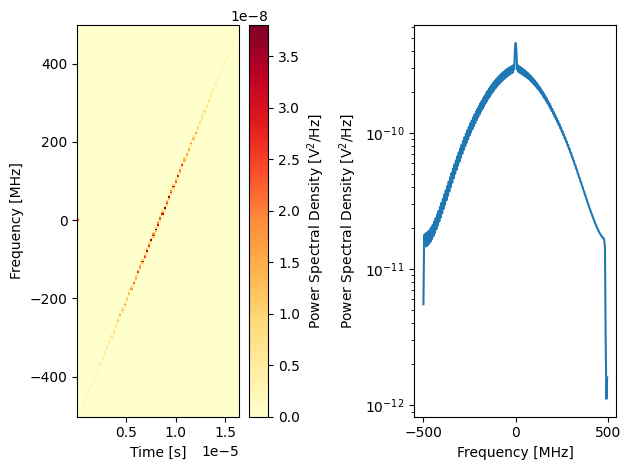

In [17]:
trace = np.array(data["acquisition"]["scope"]["path0"]["data"]) + 1j * np.array(
    data["acquisition"]["scope"]["path1"]["data"]
)
plot_spectrogram(trace)

Note the difference in timescale to before. In the spectrogram we can see the intended spectrum of the chirp.
And finally, we can visualize the chirp pulse. For better clarity, we show the low frequency parts around 8400ns.

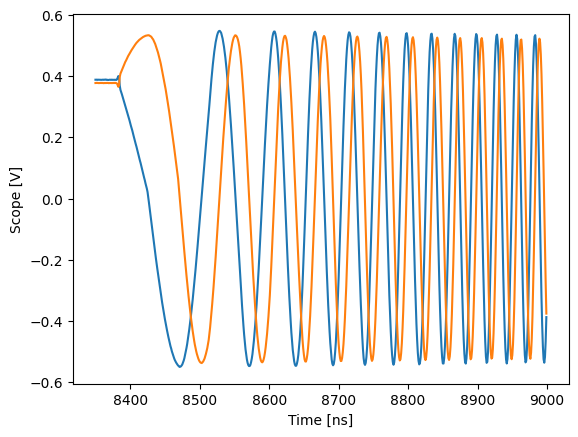

In [18]:
plot_scope(trace, 8350, 9000)

## Timings of the Q1 and realtime processors
The sequencer has a real-time pipeline that generates the output and a classical pipeline responsible for logic and filling the queue of the real-time pipeline. This queue is 32 instructions long and starts pre-filled when the sequencer is started. If the runtime of classical instructions is shorter than the corresponding real-time instructions, the sequencer will stop. See also in the documentation of the [sequencer](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/cluster/q1_sequence_processor.html#program).

We can see this by running the same program as before, but with reduced time between frequency steps:

In [19]:
step_time = 40  # this will cause stalling

n_steps = int(16384 / step_time)
step_freq = (stop_freq - start_freq) / n_steps
print(f"{n_steps} steps with step size {step_freq/1e6} MHz")

# Convert frequencies to multiples of 0.25 Hz
nco_int_start_freq = int(4 * start_freq)
nco_int_step_freq = int(4 * step_freq)

# For plotting, convert the NCO integer values back to frequencies
nco_sweep_range = np.arange(nco_int_start_freq, 4 * stop_freq, nco_int_step_freq) / 4.0

409 steps with step size 2.4449877750611244 MHz


In [20]:
acquisitions = {"acq": {"num_bins": 1, "index": 0}}

setup = f"""
    move {n_averages}, R2

avg_loop:
    move {n_steps}, R1  # n_steps
    move    0, R0          # frequency
    nop
"""

# To get a negative starting frequency, we subtract a positive number from 0
if start_freq <= 0:
    setup += f"""
    sub R0, {-nco_int_start_freq}, R0
    """
else:
    setup += f"""
    add R0, {nco_int_start_freq}, R0
    """

# Play a chirped pulse
chirp = (
    setup
    + f"""
    reset_ph
    set_freq 0
    upd_param 200
    acquire 0,0,4                         # Start acquisition. This is not blocking

nco_set:
    set_freq        R0                    # Set the frequency
    add             R0,{nco_int_step_freq}, R0  # Update the frequency register
    upd_param       {step_time}
    loop            R1, @nco_set          # Loop over all frequencies

    wait            10000
    loop            R2, @avg_loop

    stop                                  # Stop
"""
)

# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": {},
    "weights": {},
    "acquisitions": acquisitions,
    "program": chirp,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

In [21]:
readout_module.sequencer0.sequence("sequence.json")

readout_module.arm_sequencer(0)
readout_module.start_sequencer()

# Wait for the sequencer to stop with a timeout period of one minute.
readout_module.get_acquisition_status(0, timeout=1)

# Move acquisition data from temporary memory to acquisition list.
readout_module.store_scope_acquisition(0, "acq")
data = readout_module.get_acquisitions(0)["acq"]

As can be seen from the red LEDs on the front of your Cluster, the Q1 processor has stalled, and the program stopped.

In [22]:
print(readout_module.sequencer0.get_sequencer_status())

Status: STOPPED, Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, SEQUENCE_PROCESSOR_RT_EXEC_COMMAND_UNDERFLOW


We can also see on the scope that the chirp has been stopped prematurely.

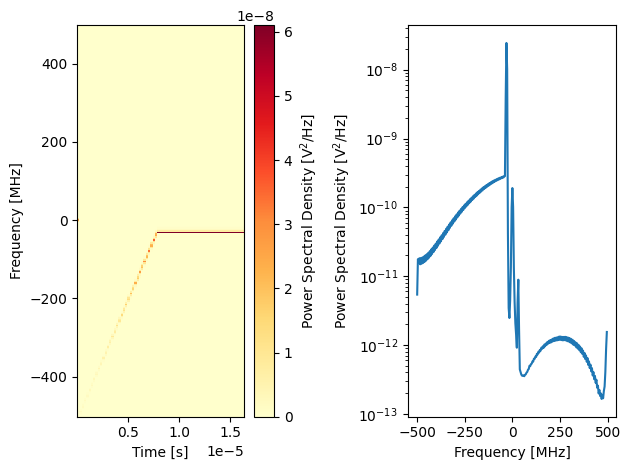

In [23]:
trace = np.array(data["acquisition"]["scope"]["path0"]["data"]) + 1j * np.array(
    data["acquisition"]["scope"]["path1"]["data"]
)
plot_spectrogram(trace)

Before continuing, we clear the flags on the qrm:

In [24]:
cluster.clear()

If we want to the chirp to use as many updates as possible, we need to unroll the loop. This way, we can reduce the time per frequency step down to 8ns: `set_freq, upd_param` both take 4ns on the Q1 processor.

In [25]:
step_time = 8

n_steps = int(16384 / step_time)
step_freq = (stop_freq - start_freq) / n_steps
print(f"{n_steps} steps with step size {step_freq/1e6} MHz")

# Convert frequencies to multiples of 0.25 Hz
nco_int_start_freq = int(4 * start_freq)
nco_int_step_freq = int(4 * step_freq)

# For plotting, convert the NCO integer values back to frequencies
nco_sweep_range = np.arange(nco_int_start_freq, 4 * stop_freq, nco_int_step_freq) / 4.0

2048 steps with step size 0.48828125 MHz


This does not leave room for a loop, which would take an additional 24ns. However, we can use the instruction memory of the Q1 processor:

In [26]:
chirp = f"""
    move {n_averages}, R2

avg_loop:
    move    0, R0          # frequency
    nop
"""

# To get a negative starting frequency, we subtract a positive number from 0
if start_freq <= 0:
    chirp += f"""
    sub R0, {-nco_int_start_freq}, R0
    """
else:
    chirp += f"""
    add R0, {nco_int_start_freq}, R0
    """

chirp += """
    reset_ph
    set_freq 0
    upd_param 200
    acquire 0,0,4                         # Start acquisition. This is not blocking

"""
# unroll the loop into individual commands

for frequency in nco_sweep_range:
    chirp += f"""
    set_freq        {int(4*frequency)}                    # Set the frequency
    upd_param       {step_time}
"""

chirp += """

    wait            10000
    loop            R2, @avg_loop

    stop                                  # Stop
"""
# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": {},
    "weights": {},
    "acquisitions": acquisitions,
    "program": chirp,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

In [27]:
readout_module.sequencer0.sequence("sequence.json")

Now we execute the program and plot the spectrogram:

In [28]:
%%time
readout_module.arm_sequencer(0)
readout_module.start_sequencer()

# Wait for the sequencer to stop with a timeout period of one minute.
readout_module.get_acquisition_status(0, timeout=1)

# Move acquisition data from temporary memory to acquisition list.
readout_module.store_scope_acquisition(0, "acq")
data = readout_module.get_acquisitions(0)["acq"]

CPU times: total: 0 ns
Wall time: 52.6 ms


Note that the execution time is comparable to the other chirped measurements, but with more than double the number of points.

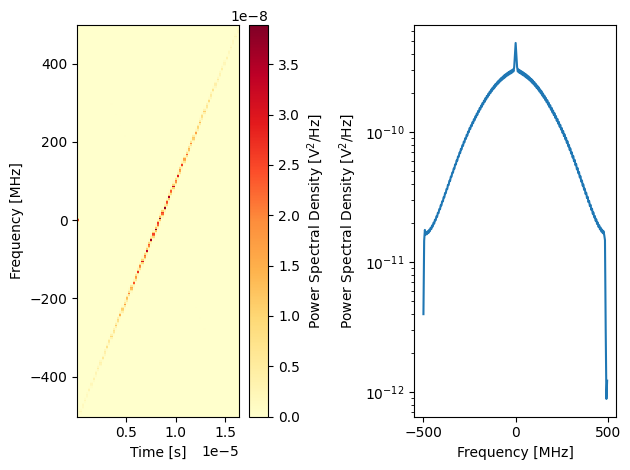

In [29]:
trace = np.array(data["acquisition"]["scope"]["path0"]["data"]) + 1j * np.array(
    data["acquisition"]["scope"]["path1"]["data"]
)
plot_spectrogram(trace)

## Phase updates

### Virtual Z gates
In addition to fast frequency updates, the sequencer also supports real-time changes of the NCO phase. In particular for superconducting qubits, this can be used for a so-called virtual $Z$ gate, see [McKay et al. (2016)](https://arxiv.org/abs/1612.00858).
The virtual $Z$ gate is a change of reference frame rather than a physical operation. Therefore, it is instantaneous and near perfect - the dominant error being that the NCO has a finite resolution of $10^9$ different phases. Below, we will demonstrate how to to use a virtual Z to use the same pulse for both $X$ and $Y$ rotations.

As the sequencer internally only supports integer values, we must first convert the phase into an integer multiple of $360/10^{9}$ degree:

In [30]:
int_90 = int(90 * (1e9 / 360))
int_270 = int(270 * (1e9 / 360))

In [31]:
# Waveforms
waveform_len = 1000
waveforms = {
    "gaussian": {
        "data": gaussian(waveform_len, std=0.133 * waveform_len).tolist(),
        "index": 0,
    },
}

# Acquisitions
acquisitions = {"scope": {"num_bins": 1, "index": 0}}

# Program
virtual_z = f"""
acquire         0,0,4
reset_ph
play            0,0,{waveform_len}      # X90
# This is equivalent to Y90, but uses the same waveform as X90
set_ph_delta    {int_90}     # Z90
play            0,0,{waveform_len}      # X90
set_ph_delta    {int_270}    # Z-90
play            0,0,{waveform_len}      # X90
stop
"""

# Write sequence to file.
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(
        {
            "waveforms": waveforms,
            "weights": {},
            "acquisitions": acquisitions,
            "program": virtual_z,
        },
        file,
        indent=4,
    )
    file.close()

In [32]:
# Program sequencers. But first we reset the cluster
cluster.reset()

readout_module.sequencer0.sequence("sequence.json")

readout_module.disconnect_outputs()
readout_module.disconnect_inputs()

# Configure channel map
readout_module.sequencer0.connect_sequencer("io0_1")
readout_module.sequencer0.nco_freq(3e6)

# Enable modulation
readout_module.sequencer0.mod_en_awg(True)
readout_module.sequencer0.demod_en_acq(True)

# Enable hardware averaging for the scope
readout_module.scope_acq_avg_mode_en_path0(True)
readout_module.scope_acq_avg_mode_en_path1(True)

readout_module.sequencer0.integration_length_acq(MAXIMUM_SCOPE_ACQUISITION_LENGTH)

Now we can run the program and look at the scope acquisition.

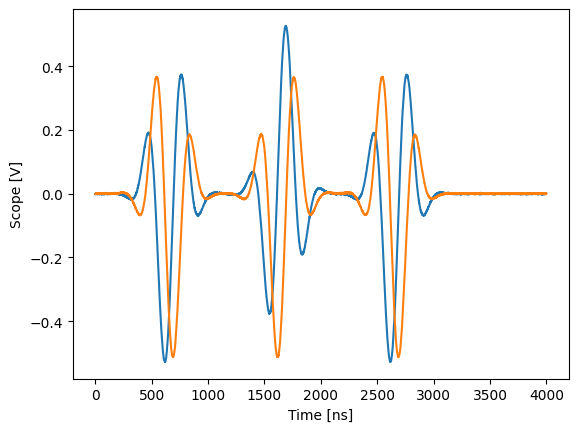

In [33]:
# Start the sequence
readout_module.arm_sequencer(0)
readout_module.start_sequencer()

# Wait for the sequencer to stop
readout_module.get_acquisition_status(0, timeout=1)

# Get acquisition data
readout_module.store_scope_acquisition(0, "scope")
acq = readout_module.get_acquisitions(0)

trace = np.asarray(acq["scope"]["acquisition"]["scope"]["path0"]["data"]) + 1j * np.asarray(
    acq["scope"]["acquisition"]["scope"]["path1"]["data"]
)

plot_scope(trace, 0, 4000)

### Chirped pulses using the phase update
As an exercise combining the concepts from this notebook, we can also create a chirp using only phase updates. This is purely educational and should not be used in an experiment. Again, we do not use a loop, and use the instruction memory instead to make the step size smaller.

In [34]:
n_averages = 100
n_steps = int(16384 / (20))

acquisitions = {"acq": {"num_bins": 1, "index": 0}}


phase_chirp = f"""
    move {n_averages}, R2

avg_loop:
    move    0, R0                         # phase update step size
    reset_ph
    set_freq 0
    upd_param 200
    acquire 0,0,4                         # Start acquisition. This is not blocking

nco_set:
"""
# step the phase with increasing step size
# The order is chosen such that we do not need `nop`
for _ in range(n_steps):
    phase_chirp += f"""
    set_ph_delta    R0
    add             R0, {int(1e9/(4*n_steps))}, R0      # increase the 'frequency'
    upd_param       20
"""
phase_chirp += """
    wait            10000
    loop            R2, @avg_loop

    stop                                  # Stop
"""

# Write sequence to file.
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(
        {
            "waveforms": waveforms,
            "weights": {},
            "acquisitions": acquisitions,
            "program": phase_chirp,
        },
        file,
        indent=4,
    )
    file.close()

We can run this with the same settings as the chirps before:

In [35]:
readout_module.sequencer0.sequence("sequence.json")

# Set DC Offset
readout_module.sequencer0.offset_awg_path0(1)
readout_module.sequencer0.offset_awg_path1(1)

readout_module.arm_sequencer(0)
readout_module.start_sequencer()

# Wait for the sequencer to stop with a timeout period of one minute.
readout_module.get_acquisition_status(0, timeout=1)

# Move acquisition data from temporary memory to acquisition list.
readout_module.store_scope_acquisition(0, "acq")
data = readout_module.get_acquisitions(0)["acq"]

In the spectrogram we can see a slow frequency sweep - plus high frequency components. The reason for those is easily visible in the scope, the "sine" wave is not smooth, but instead made up of many square pulses (as expected).

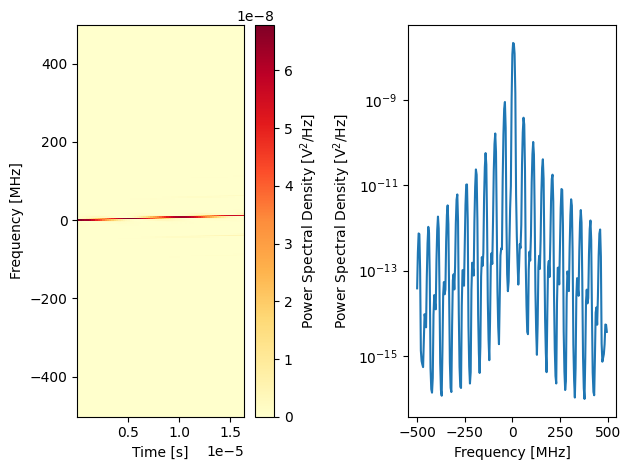

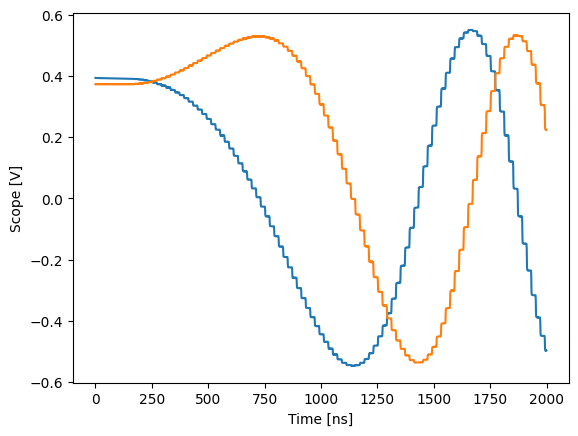

In [36]:
trace = np.array(data["acquisition"]["scope"]["path0"]["data"]) + 1j * np.array(
    data["acquisition"]["scope"]["path1"]["data"]
)
plot_spectrogram(trace)

plot_scope(trace, 0, 2000)

Using registers, we can also do negative phase steps:

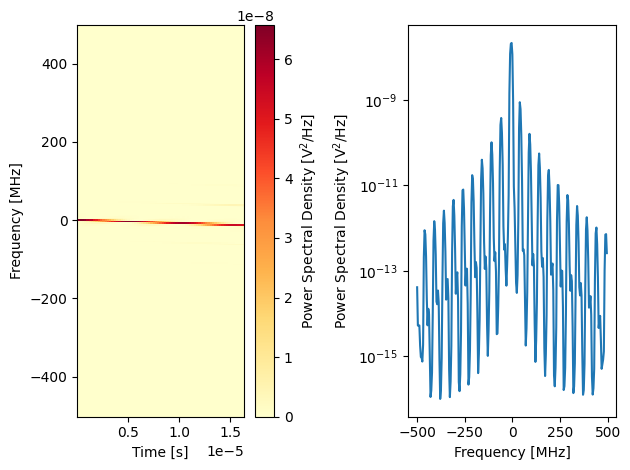

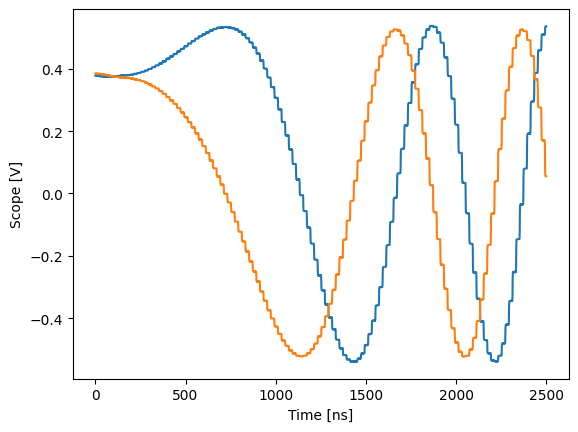

In [37]:
n_averages = 100
n_steps = int(16384 / (20))

acquisitions = {"acq": {"num_bins": 1, "index": 0}}


phase_chirp = f"""
    move {n_averages}, R2

avg_loop:
    move    0, R0                         # phase update step size
    reset_ph
    upd_param 200
    set_freq 0
    acquire 0,0,4                         # Start acquisition. This is not blocking

nco_set:
"""
# step the phase with increasing (negative) step size
for _ in range(n_steps):
    phase_chirp += f"""
    set_ph_delta    R0
    sub             R0, {int(1e9/(4*n_steps))}, R0      # increase the step size ('frequency')
    upd_param       20
"""

phase_chirp += """
    wait            10000
    loop            R2, @avg_loop

    stop                                  # Stop
"""

# Write sequence to file.
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(
        {
            "waveforms": waveforms,
            "weights": {},
            "acquisitions": acquisitions,
            "program": phase_chirp,
        },
        file,
        indent=4,
    )
    file.close()

readout_module.sequencer0.sequence("sequence.json")

readout_module.arm_sequencer(0)
readout_module.start_sequencer()

# Wait for the sequencer to stop with a timeout period of one minute.
readout_module.get_acquisition_status(0, timeout=1)

# Move acquisition data from temporary memory to acquisition list.
readout_module.store_scope_acquisition(0, "acq")
data = readout_module.get_acquisitions(0)["acq"]

trace = np.array(data["acquisition"]["scope"]["path0"]["data"]) + 1j * np.array(
    data["acquisition"]["scope"]["path1"]["data"]
)
plot_spectrogram(trace)

plot_scope(trace, 0, 2500)

## Stop

Finally, let's stop the playback and close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before
closing the connection by uncommenting the corresponding lines.

In [38]:
# Stop both sequencers.
readout_module.stop_sequencer()

# Print status of both sequencers (should now say it is stopped).
print(readout_module.get_sequencer_status(0))
print(readout_module.get_sequencer_status(1))
print()

# Print an overview of the instrument parameters.
print("Snapshot:")
readout_module.print_readable_snapshot(update=True)

# Reset the cluster
cluster.reset()
print(cluster.get_system_status())

Status: STOPPED, Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE
Status: STOPPED, Flags: FORCED_STOP

Snapshot:


cluster0_module4:
	parameter                    value
--------------------------------------------------------------------------------
in0_gain                      :	-6 (dB)
in0_offset                    :	0 (V)
in1_gain                      :	-6 (dB)
in1_offset                    :	0 (V)
marker0_inv_en                :	False 
marker1_inv_en                :	False 
marker2_inv_en                :	False 
marker3_inv_en                :	False 
out0_offset                   :	0 (V)
out1_offset                   :	0 (V)
present                       :	True 
scope_acq_avg_mode_en_path0   :	True 
scope_acq_avg_mode_en_path1   :	True 
scope_acq_sequencer_select    :	0 
scope_acq_trigger_level_path0 :	0 
scope_acq_trigger_level_path1 :	0 
scope_acq_trigger_mode_path0  :	sequencer 
scope_acq_trigger_mode_path1  :	sequencer 


cluster0_module4_sequencer0:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	I 
connect_out1                     :	Q 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	True 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	16384 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	True 
nco_freq                         :	3e+06 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (n

cluster0_module4_sequencer1:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	off 
connect_acq_Q                    :	off 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer2:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	off 
connect_acq_Q                    :	off 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer3:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	off 
connect_acq_Q                    :	off 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer4:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	off 
connect_acq_Q                    :	off 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer5:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	off 
connect_acq_Q                    :	off 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

Status: OKAY, Flags: NONE, Slot flags: NONE
